# Modeling Spark Applications

Apache Spark is a very flexible distributed system. As a result of its flexibility, it is difficult to predict the total duration of different applications types. In this work, we use machine learning to find a model that can predict different application types. In the following sections, we analyze two applications: finding the Wikipedia top contributors (inspired by Spark Summit 2014) and HiBench Sort benchmark.

In [1]:
# Notebook initialization

try:
    initialized
except NameError:
    ## Matplotlib one-time configuration
    %matplotlib inline
    initialized = True

# Python's imports
import pickle

# 3rd-party libraries
from IPython.display import display
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV

# My code
import helper
from lib import Humanizer, Model, Plotter
from lib.hbsort import DataFrameBuilder as DFBuilderSort
from lib.wikipedia import DataFrameBuilder as DFBuilderWiki
from settings import *

In [2]:
# 2 Apache Spark applications
APPS = ('wikipedia',      # Wikipedia application 
        'hbsort')         # HiBench Sort benchmark
# 2 sets for every application:
SETS = ('profiling',      # less workers and input data
        'target')         # we want to predict the target set 

# All DataFrames are stored in the "dfs" dictionary
dfs = {app: {s: {} for s in SETS} for app in APPS}

# Wikipedia's Top 10 Contributors
This application outputs the top 10 contributors of the English Wikipedia. The input is the information about the last version of all English Wikipedia articles in JSON format. In the article information, we can find who was the last person to edit it and this counts as one contribution for that person. We measured the first execution of a SQL query that returns the top 10 contributors.

In [3]:
dfb = DFBuilderWiki()

caption = 'Target executions that we want to predict, with different numbers of workers.' \
          ' Total input size is 45 GB.\n'
df = dfb.get_target()
h = Humanizer()
dfs['wikipedia']['target']['original'] = helper.remove_outliers(df, h, caption)

caption = 'Profiling executions with less workers and input data. They are used to generate the model.'
df = helper.get_wiki_profiling_df(dfb)
h = Humanizer(size=Humanizer.SIZE_MIB)
dfs['wikipedia']['profiling']['original'] = helper.remove_outliers(df, h, caption)

,workers,input size (GiB),mean (sec),samples,outliers,not outliers
0,4,45,184.20,30,2,28
1,8,45,103.31,30,1,29
2,16,45,64.58,30,2,28
3,32,45,43.88,30,2,28
4,64,45,39.23,30,1,29


Target executions that we want to predict, with different numbers of workers. Total input size is 45 GB.



,workers,input size (MiB),mean (sec),samples,outliers,not outliers
0,1,128,20.44,10,0,10
1,1,256,20.01,10,0,10
2,1,512,23.70,10,0,10
3,1,1024,29.96,10,0,10
4,2,1024,23.53,10,2,8
5,4,1024,20.85,10,0,10


Profiling executions with less workers and input data. They are used to generate the model.


# HB Sort
This is the Sort application from the HiBench suite. It sorts text input data, which is randomly generated. More details in its [GitHub page](https://github.com/intel-hadoop/HiBench) (there's also a paper about it with more details of the workload).

In [4]:
dfb = DFBuilderSort()

caption = 'Target executions that we want to predict, with different numbers of workers.' \
          ' We used two problem sizes from the HiBench suite.\n'
df = helper.get_sort_target_df(dfb)
dfs['hbsort']['target']['original'] = helper.remove_outliers(df, Humanizer(), caption)

caption = 'Profiling executions with less workers and input data. They are used to generate the model.'
df = dfb.get_profiling()
h = Humanizer(size=Humanizer.SIZE_MIB)
dfs['hbsort']['profiling']['original'] = helper.remove_outliers(df, h, caption)

dfb.free()

,input size (GiB),workers,mean (sec),samples,outliers,not outliers
0,3,1,392.65,10,0,10
1,3,2,133.99,10,1,9
2,3,4,87.36,10,1,9
3,3,8,61.92,10,1,9
4,3,16,47.48,10,0,10
5,31,16,328.36,10,1,9
6,31,32,284.54,10,1,9
7,31,64,286.15,10,2,8
8,31,128,174.30,10,0,10


Target executions that we want to predict, with different numbers of workers. We used two problem sizes from the HiBench suite.



,input size (MiB),workers,mean (sec),samples,outliers,not outliers
0,263,1,31.24,10,1,9
1,263,2,26.29,10,1,9
2,526,1,49.05,10,2,8
3,526,2,36.14,10,0,10
4,526,4,27.77,10,1,9
5,1051,1,85.56,10,2,8
6,1051,2,54.80,10,3,7
7,1051,4,71.97,10,0,10
8,1051,8,29.82,10,0,10
9,2102,2,92.93,10,1,9


Profiling executions with less workers and input data. They are used to generate the model.


# Models
We are going to try many (tens of thousands) different feature sets with Ridge penalized linear regression. There's also 5 different penalization multipliers (alpha values) that will be tested using cross validation (CV) for each feature set.

For each feature set, we train the model with the profiling experiment results and the best alpha is chosen. Then, we use the same model to predict the target executions' durations. Finally, we calculate 3 metrics for these predictions:
* MAE: Mean Absolut Error
* MPE: Mean Percentage Error
* RMSE: Root Mean Square Error

This is done for both applications and, based on these metrics, we will choose the best feature set to predict them.

## Linear Model and Features
In this section, we define the linear model and calculate other features than the number of workers and input size.

In [5]:
# Linear Regression with penalization to avoid overfitting
LINEAR_MODELS = (RidgeCV(normalize=True, alphas=(0.01, 0.1, 1, 3, 10)),)

DEGREE = 2  # columns "a" and "b" become "a", "a^2", "a*b", "b", "b^2"
_COMMON_COLS = [
    ('input', lambda df: df.input),
    ('workers', lambda df: df.workers),
    ('ms', lambda df: df.ms),  # this is not a feature, but the duration we want to predict
]

# Features to be added
COLS = _COMMON_COLS + [
    ('1/workers', lambda df: 1/df.workers),
    ('log(input_per_worker)', lambda df: np.log2(df.input/df.workers)),
    ('log(input)', lambda df: np.log2(df.input)),
    ('log(workers)', lambda df: np.log2(df.workers)),
]

# Features to predict the the duration log
COLS_LOG = _COMMON_COLS

In [6]:
# Pre-calculate all the features

for app in APPS:
    for s in SETS:
        df = dfs[app][s]
        df['features'] = helper.get_cols(df['original'], COLS, DEGREE)
        df['features_log'] = helper.get_log_cols(df['original'], COLS_LOG)

In [7]:
# Reducing the number of features, so we can analyze the results today.

df = dfs['wikipedia']['profiling']['features']
features = df.columns.tolist()
features.remove('ms')
n_features = len(features)
n_models = 2**n_features * len(LINEAR_MODELS)

print('Total number of features after polynomial expansion is {:d}. Feature\'s powerset cardinality is {:d} '
      'and it would take too long to compute.'.format(n_features, n_models))

removable_features = [
  'input * log(input_per_worker)',
  'input * log(input)',
  'input * log(workers)',
  'workers * 1/workers',
  'workers * log(input_per_worker)',
  'workers * log(input)',
  'workers * log(workers)',
  '1/workers * log(input_per_worker)',
  '1/workers * log(input)',
  '1/workers * log(workers)',
  'log(input_per_worker) * log(input)',
  'log(input_per_worker) * log(workers)']

for feature in removable_features:
    features.remove(feature)
n_features = len(features)
n_models = 2**n_features * len(LINEAR_MODELS)

print('\nAfter removing some features, we have {:d}. Feature\'s powerset cardinality is now {:d} '
      'and we are going to evaluate every feature subset. '
      'The final feature list is:\n    - {}'.format(n_features, n_models, '\n    - '.join(features)))

Total number of features after polynomial expansion is 27. Feature's powerset cardinality is 134217728 and it would take too long to compute.

After removing some features, we have 15. Feature's powerset cardinality is now 32768 and we are going to evaluate every feature subset. The final feature list is:
    - input
    - workers
    - 1/workers
    - log(input_per_worker)
    - log(input)
    - log(workers)
    - (input)^2
    - input * workers
    - input * 1/workers
    - (workers)^2
    - (1/workers)^2
    - (log(input_per_worker))^2
    - (log(input))^2
    - log(input) * log(workers)
    - (log(workers))^2


## Evaluation
For every possible feature combination, we calculate the errors MAE, MPE and RMSE for every application and set.

In [8]:
# Evaluation begins. This is the slowest cell. Good time for a coffee.

# All pandas' DataFrames are stored in the "dfs" dictionary.
eval_raw = {app: {s: {} for s in SETS} for app in APPS}

for app in APPS:
    prof = dfs[app]['profiling']['features']
    trgt = dfs[app]['target']['features']
    %time res = helper.evaluate_exp(prof, [prof, trgt], LINEAR_MODELS, features=features)
    eval_raw[app]['profiling'], eval_raw[app]['target'] = res

CPU times: user 9.51 s, sys: 207 ms, total: 9.71 s
Wall time: 1min 36s
CPU times: user 9.37 s, sys: 237 ms, total: 9.61 s
Wall time: 1min 43s


In [9]:
# Now, a regression with logs using the duration log.

df = dfs['wikipedia']['profiling']['features_log']
features_log = [col for col in df.columns if col != 'log(ms)']
print('For regression with logs, we will use {:d} features: {}.\n'.format(
        len(features_log), ', '.join(features_log)))

for app in APPS:
    prof = dfs[app]['profiling']['features_log']
    trgt = dfs[app]['target']['features_log']
    %time res = helper.evaluate_exp(prof, [prof, trgt], LINEAR_MODELS, is_log=True)
    eval_raw[app]['profiling'] += res[0]
    eval_raw[app]['target'] += res[1]

For regression with logs, we will use 2 features: log(input), log(workers).

CPU times: user 16.7 ms, sys: 66.7 ms, total: 83.3 ms
Wall time: 142 ms
CPU times: user 10 ms, sys: 26.7 ms, total: 36.7 ms
Wall time: 143 ms


In [10]:
# Create a DataFrame from the raw evaluation results
evaluation = {}
for app in APPS:
    evaluation[app] = {}
    for s, res in eval_raw[app].items():
        evaluation[app][s] = helper.format_results(res)

In [11]:
# Creating the rank columns

def get_rank(df, col):
    sorted_index = df.sort_values(col).index
    return [np.where(sorted_index == v)[0][0] for v in df.index]

errs = ('MAE', 'MPE', 'RMSE')
labels = ('value', 'rank')
index = pd.MultiIndex.from_product((APPS, SETS, errs, labels), names=['app', 'set', 'error', ''])
df_cmp = pd.DataFrame(columns=index)
for app in APPS:
    for s in SETS:
        for err in errs:
            df_cmp.loc[:, (app, s, err, 'value')] = evaluation[app][s][err]
            df_cmp.loc[:, (app, s, err, 'rank')] = get_rank(evaluation[app][s], err)

To compare different metrics, we assign them ranks. The best model found for a given metric has rank 0. Then, we sort the models by the sum of all metrics' rank of all applications (target execution). Finally, we choose the first model, the one with the lowest sum.

In [12]:
rank_sum = sum(df_cmp.loc[:, (app, 'target', err, 'rank')] for app in APPS for err in errs).sort_values()
rank_sum.index.name = 'model_nr'
display(pd.DataFrame({'rank sum':rank_sum}).head())

prof_cols = [('wikipedia', 'profiling'), ('hbsort', 'profiling')]
df_cmp.ix[rank_sum.index].drop(prof_cols, axis=1).head()

,rank sum
model_nr,
149,52
192,53
755,58
1041,2832
227,3300


/usr/lib/python3.5/site-packages/ipykernel/kernelbase.py:228: PerformanceWarning: indexing past lexsort depth may impact performance.
  handler(stream, idents, msg)


app      wikipedia                            hbsort                         \
set         target                            target                          
error          MAE        MPE       RMSE         MAE        MPE        RMSE   
             value rank value rank value rank  value rank value rank  value   
model_nr                                                                      
149           2.34    1  3.30    1  3.37    1  43.23    1 16.40    8 110.84   
192           1.87    0  2.93    0  3.21    0  43.34    3 16.44    9 110.96   
755           3.16    2  4.12    2  4.03    2  43.25    2 16.39    7 111.14   
1041          8.21  698 14.29  690  8.83  642  86.97  258 31.64   79 140.27   
227           8.65  973 14.69  770  9.16  780  86.42  245 31.40   74 139.65   

app            
set            
error          
         rank  
model_nr       
149        40  
192        41  
755        43  
1041      465  
227       458

The table on the top shows the sum of all ranks that are depicted in the second table. Both tables are sorted by the rank sum.

In [13]:
df_cmp.ix[rank_sum.index].head()

app      wikipedia                                                             \
set      profiling                               target                         
error          MAE         MPE        RMSE          MAE        MPE       RMSE   
             value  rank value  rank value  rank  value rank value rank value   
model_nr                                                                        
149           0.89  6761  4.16  6767  1.26  5149   2.34    1  3.30    1  3.37   
192           0.89  6963  4.17  6903  1.26  9655   1.87    0  2.93    0  3.21   
755           0.89  6740  4.16  6786  1.26  4168   3.16    2  4.12    2  4.03   
1041          0.88  1706  4.14  1620  1.26  7529   8.21  698 14.29  690  8.83   
227           0.88  2370  4.14  1700  1.26  9030   8.65  973 14.69  770  9.16   

app              hbsort                                                    \
set           profiling                                 target              
error               MAE          MPE        RMSE           MAE        MPE   
         rank     value   rank value  rank value   rank  value rank value   
model_nr                                                                    
149         1      6.35   4422 11.57  2426 13.30  31744  43.23    1 16.40   
192         0      6.35   4402 11.58  2438 13.30  31749  43.34    3 16.44   
755         2      6.36   4558 11.56  2409 13.30  31747  43.25    2 16.39   
1041      642      6.77  15804 12.63  5455 13.51  31932  86.97  258 31.64   
227       780      6.74  15580 12.56  4988 13.50  31931  86.42  245 31.40   

app                        
set                        
error           RMSE       
         rank  value rank  
model_nr                   
149         8 110.84   40  
192         9 110.96   41  
755         7 111.14   43  
1041       79 140.27  465  
227        74 139.65  458

As we can see in the profiling evaluation results, the best models to predict the target executions are not the best ones to predict the profiling durations. Thus, by only making a regression in the profiling results, one would have worse predictions. That is why we need to choose a model by analyzing the target scores.

## Best Model

Now, we visualize the chosen model for both applications. The model details are:

In [14]:
model_nr = rank_sum.index[0]
model = pickle.loads(eval_raw['wikipedia']['target'][model_nr]['model_dump'])
print(str(model))

      linear model: RidgeCV
      duration log: False
            params: alphas: (0.01, 0.1, 1, 3, 10), best: 0.01
number of features: 3
          features: input, log(input_per_worker), input * 1/workers


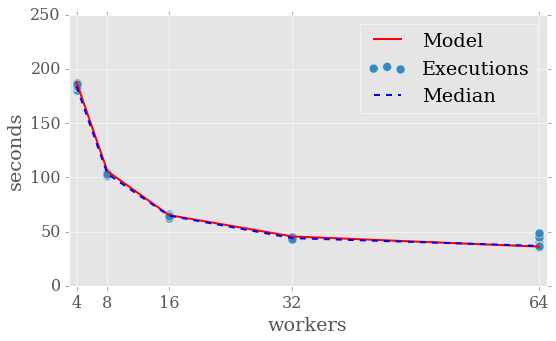

In [15]:
prof = dfs['wikipedia']['profiling']['features']
trgt = dfs['wikipedia']['target']['features']
model.fit(prof)
plotter = Plotter(xlim=(3, 65))
plotter.plot_model(model, trgt)

Prediction of the Wikipedia application target execution duration.

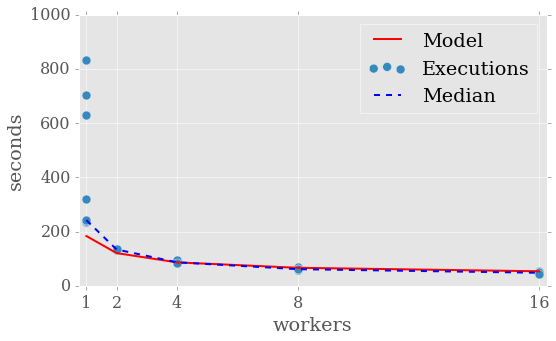

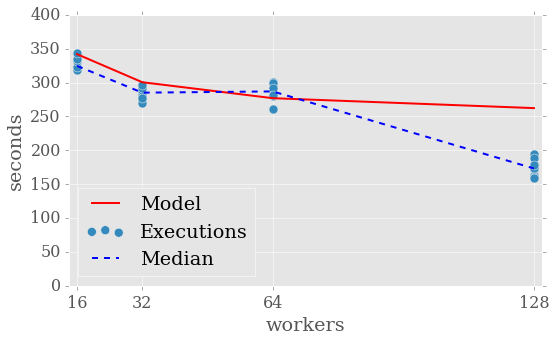

In [16]:
prof = dfs['hbsort']['profiling']['features']
trgt = dfs['hbsort']['target']['features']
model.fit(prof)
plotter = Plotter(xlim=(0.75, 16.25))
plotter.plot_model(model, trgt[trgt.input < 15 * 1024**3])
plotter = Plotter(xlim=(14, 130))
plotter.plot_model(model, trgt[trgt.input > 15 * 1024**3])

The top figure is the result of the HiBench Sort application with 3-GB input. The second figure uses 31-GB of data.

# Conclusion
There are two major findings in this work. One is that the best model to predict the profiling set performs poorly in the target prediction. The other is that, despite of being two different applications, we were able to find one model that has good results for all target number of workers of the Wikipedia application and also for the HiBench Sort benchmark, from 2 to 64 workers using 3 and 31 GB of input data.